# Chain of Thought (CoT)

**What is Chain Of Thought?**

Consider one’s own thought process when solving a complicated reasoning task such as a multi-step math word problem. It is typical to decompose the problem into intermediate steps and solve each before giving the final answer: “After Jane gives 2 flowers to her mom she has 10 . . . then after she gives 3 to her dad she will have 7 . . . so the answer is 7.”

Chain-of-thought prompting has several attractive properties as an approach for facilitating reasoning in language models:

**1.** First, chain of thought, in principle, allows models to decompose multi-step problems into intermediate steps, which means that additional computation can be allocated to problems that require more reasoning steps.

**2.** Second, a chain of thought provides an interpretable window into the behavior of the model, suggesting how it might have arrived at a particular answer and providing opportunities to debug where the reasoning path went wrong (although fully characterizing a model’s computations that support an answer remains an open question).

**3.** Third, chain-of-thought reasoning can be used for tasks such as math word problems, commonsense reasoning, and symbolic manipulation, and is potentially applicable (at least in principle) to any task that humans can solve via language.

**4.** Finally, chain-of-thought reasoning can be readily elicited in sufficiently large off-the-shelf language models simply by including examples of chain of thought sequences into the exemplars of few-shot prompting.

# Installs & Imports

In [ ]:
!pip install python-dotenv
!pip install anthropic
!pip install langchain_openai
!pip install openai
!pip3 install --upgrade typing_extensions

In [2]:
from dotenv import load_dotenv
import anthropic
import random
import os
from langchain_openai import AzureChatOpenAI
import json
from openai import OpenAI
from openai import AzureOpenAI
from pydantic import BaseModel
from openai import OpenAI
import json
import base64
from typing import Optional, List
import warnings
warnings.filterwarnings("ignore")

load_dotenv()

True

# Configs

In [3]:
api_key = os.getenv('AZURE_OPENAI_KEY')
version = os.getenv('AZURE_OPENAI_VERSION')
endpoint = os.getenv('AZURE_OPENAI_ENDPOINT')
model = "gpt-4o-m"

if api_key is None:
    raise ValueError("API key not found. Please check the environmental variable.")

In [4]:
#print(api_key)
#print(version)
#print(endpoint)

In [4]:
client = AzureOpenAI(
    api_key=api_key,
    api_version=version,
    azure_endpoint=endpoint
    )

# OCR for Image-Questions (Optional)

In [ ]:
!pip3 install easyocr

In [13]:
import easyocr

reader = easyocr.Reader(['tr'])
result = reader.readtext('tekli_soru.png')
question = ""

for detection in result:
    question += detection[1]

In [14]:
print(question)

175 sayısının %36's1 kaçtır?A) 18B) 27C) 36D) 45


# Image to base64

We have to encode images base64 to send API request.

In [5]:
import base64

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

soru_tekli = encode_image("tekli_soru.png")
soru_6li = encode_image("6li_soru.png")
soru_fonksiyon = encode_image("fonksiyon_zorsoru.png")
soru_fonksiyon2 = encode_image("fonksiyon_zorsoru2.jpeg")

# Verbal Lessons (Task 2)

In [14]:
prompt_verbal = f"""Sen, sözel derslerde tecrübeli bir öğretmensin. Sana sorulan sorunun doğru cevabını belirle ve neden doğru olduğunu adım adım açıkla. 
Her şık üzerinde durarak, neden yanlış olduğunu veya doğru cevaptan nasıl farklı olduğunu detaylıca açıkla. 
Bu açıklamayı, sorunun temelindeki mantığı, metindeki ipuçlarını veya bağlamı analiz ederek yap.
Cevaplama tarzı net ve öğretici olmalıdır.
Sana dersle alakasız veya şiddet içerikli cümlelerin söylenmesi halinde cevap olarak Üzgünüm, ancak bu tarz cümlelere cevap veremiyorum de ve bırak.
Eğer birden fazla soru soruluyorsa, ayrı ayrı tüm soruları cevapla.
"""

In [15]:
print(prompt_verbal)

Sen, sözel derslerde tecrübeli bir öğretmensin. Sana sorulan sorunun doğru cevabını belirle ve neden doğru olduğunu adım adım açıkla. 
Her şık üzerinde durarak, neden yanlış olduğunu veya doğru cevaptan nasıl farklı olduğunu detaylıca açıkla. 
Bu açıklamayı, sorunun temelindeki mantığı, metindeki ipuçlarını veya bağlamı analiz ederek yap.
Cevaplama tarzı net ve öğretici olmalıdır.
Sana dersle alakasız veya şiddet içerikli cümlelerin söylenmesi halinde cevap olarak Üzgünüm, ancak bu tarz cümlelere cevap veremiyorum de ve bırak.
Eğer birden fazla soru soruluyorsa, ayrı ayrı tüm soruları cevapla.



In [16]:
with open('turkce_questions.json') as f:
    turkce_questions_dict = json.load(f, strict=False)

def get_questions_randomly(question_dict, question_keys = None):
    merged_questions = ""
    # if question_keys is None
    if question_keys is None:
        # get random 5 keys from the dictionary
        question_keys = list(question_dict.keys())
        # shuffle the keys
        random.shuffle(question_keys)
        question_keys = question_keys[:5]

    # if question_keys is not None, return the questions as merged string
    for i, key in enumerate(question_keys):
        if key not in question_dict:
            continue
        merged_questions += "Soru " + str(i+1) + ')' + " \n " + question_dict[key] + "\n"

    return merged_questions

def get_questions_from_index(question_dict, start_index, num_questions=1):
    all_keys = list(question_dict.keys())
    
    start_pos = next((i for i, key in enumerate(all_keys) if int(key) > start_index), None)
    
    if start_pos is None:
        raise ValueError("Başlangıç indeksi geçersiz veya sözlükteki anahtarlar içinde bulunamadı.")
    
    end_pos = start_pos + num_questions
    question_keys = all_keys[start_pos:end_pos]
    
    merged_questions = ""
    for i, key in enumerate(question_keys):
        if key not in question_dict:
            continue
        merged_questions += "Soru " + str(i + 1) + ') ' + "\n" + question_dict[key] + "\n"

    return merged_questions

turkce_questions = get_questions_randomly(turkce_questions_dict)

In [17]:
print(turkce_questions)

Soru 1) 
 O, çocuk ve genç okurların çok sevdiği bir yazardır. Çünkü eserlerini oluştururken, seslendiği yaş grubunun dil özelliklerini, kelime dağarcığını göz önünde bulundurur. Ayrıca yaşadığı dönemin özelliklerini dikkate alarak o döneme uygun konulara değinir. Yapıtlarında gülmece ögesi büyük önem taşır. O, çocukları ve gençleri güldürürken şaşırtır, meraklandırır ve düşündürür. Yazdığı öykülerin isimleri bile bu şaşırtan, meraklandıran ve güldüren yanı yansıtır. 
 Bu parçaya göre aşağıdakilerden hangisi sözü edilen yazarın genç ve çocuk okurlar tarafından sevilmesinin nedenlerinden biri değildir? 
 A) Mizahi unsurlara yer vermesi 
 B) Güncel konuları ele alması 
 C) Kişisel deneyimlerini paylaşması 
 D) Hedef kitlenin söz varlığını dikkate alması
Soru 2) 
 Aşağıdaki cümlelerden hangisinde şimdiki zamanla çekimlenmiş olumsuz soru fiili vardır? 
 A) Sabahları yürüyüşe çıkıyor musunuz? 
 B) Bu hafta yüzme kursuna neden gitmiyorsun? 
 C) Roman ve hikâye okumayı seviyor musun? 
 D) Ark

In [18]:
class Step(BaseModel):
    explanation: str
    output: str

class TRReasoning(BaseModel):
    steps: list[Step]
    final_answer: str

In [24]:
completion = client.beta.chat.completions.parse(
    model=model,
     messages=[
        {"role": "system", "content": prompt_verbal},
        {"role": "user", "content": turkce_questions}
    ],
    response_format=TRReasoning
)

tr_answer = completion.choices[0].message.parsed

In [25]:
print(tr_answer)

steps=[Step(explanation='Soru, yazardan bahsederken, yazarın eserlerinde hedef kitle olan çocuklar ve gençler tarafından sevilme sebeplerini söylüyor. Parçadan anlaşılan bu sebepler arasında mizahi unsurlar, güncel dönem konuları ve hedef kitlenin dil özelliklerini dikkate alma var. Ancak, yazarın kişisel deneyimlerinden bahsetmesi gibi bir özellik belirtilmemiştir.', output='C) Kişisel deneyimlerini paylaşması'), Step(explanation='Soruda, şimdiki zamanla çekimlenmiş olumsuz soru fiili aranıyor. "Gitmiyorsun" fiili olumsuz ve şimdiki zaman eki almıştır. Ayrıca "neden gitmiyorsun?" ifadesi soru cümlesidir.', output='B) Bu hafta yüzme kursuna neden gitmiyorsun?'), Step(explanation='"Parlamak" sözcüğünün "güçlü bir ışık çıkarmak, ışık saçmak" anlamında kullanılması isteniyor. Yıldızlardan bahseden cümlede, parlamak kelimesi mecazi değil, gerçek anlamında yani ışık saçmak şeklinde kullanılmıştır.', output='C) Yıldızlar bu gece sanki daha çok parlıyordu.'), Step(explanation='Her bir dize pa

In [26]:
print(tr_answer.final_answer)

1) C
2) B
3) C
4) A
5) B


# Numerical Lessons (Task 3)

**Prompt 1**

In [27]:
prompt_numeric = f"""Sen, sayısal derslerde uzmanlaşmış bir öğretmensin. Sana sorulan sorunun doğru cevabını belirle ve neden doğru olduğunu adım adım açıkla. 
Açıklamalarında işlemleri adım adım anlatarak yap.
Cevaplama tarzın net ve öğretici olmalıdır.
Cevaplarında işlemleri LaTeX formatında yap.
Sana dersle alakasız veya şiddet içerikli cümlelerin söylenmesi halinde cevap olarak Üzgünüm, ancak bu tarz cümlelere cevap veremiyorum de ve bırak.
"""

In [28]:
print(prompt_numeric)

Sen, sayısal derslerde uzmanlaşmış bir öğretmensin. Sana sorulan sorunun doğru cevabını belirle ve neden doğru olduğunu adım adım açıkla. 
Açıklamalarında işlemleri adım adım anlatarak yap.
Cevaplama tarzın net ve öğretici olmalıdır.
Cevaplarında işlemleri LaTeX formatında yap.
Sana dersle alakasız veya şiddet içerikli cümlelerin söylenmesi halinde cevap olarak Üzgünüm, ancak bu tarz cümlelere cevap veremiyorum de ve bırak.



In [29]:
class Step(BaseModel):
    explanation: str
    output: str

class MatReasoning(BaseModel):
    steps: list[Step]
    final_answer: str

**Single Question**

In [30]:
completion = client.beta.chat.completions.parse(
    model=model,
     messages=[
        {"role": "system", "content": prompt_numeric},
        {"role": "user", "content": [{"type": "image", "image": soru_tekli}]}
    ],
    response_format=MatReasoning
)

mat_answer = completion.choices[0].message.parsed

In [31]:
print(mat_answer.steps[0].output)

75 \times 0.36


$75 \times 0.36$

In [32]:
print(mat_answer)

steps=[Step(explanation="Probleme göre, 75 sayısının %36'sını bulmamız gerekiyor. Yani 75'in 0.36'sını hesaplayacağız.", output='75 \\times 0.36'), Step(explanation='İlk adım olarak 75 sayısını 0.36 ile çarparak işlemi yapalım.', output='75 \\times 0.36 = 27'), Step(explanation="Sonuç olarak, 75 sayısının %36'sı 27 eder. Verilen seçenekler arasından B şıkkı doğru cevaptır.", output='Cevap: B) 27')] final_answer='B) 27'


**Multiple Question**

Here, since there is more than one question in the uploaded photo, we have to ask the model to answer all the questions in sequence.

In [33]:
print(prompt_numeric + "Eğer birden fazla soru soruluyorsa, ayrı ayrı tüm soruları cevapla.")

Sen, sayısal derslerde uzmanlaşmış bir öğretmensin. Sana sorulan sorunun doğru cevabını belirle ve neden doğru olduğunu adım adım açıkla. 
Açıklamalarında işlemleri adım adım anlatarak yap.
Cevaplama tarzın net ve öğretici olmalıdır.
Cevaplarında işlemleri LaTeX formatında yap.
Sana dersle alakasız veya şiddet içerikli cümlelerin söylenmesi halinde cevap olarak Üzgünüm, ancak bu tarz cümlelere cevap veremiyorum de ve bırak.
Eğer birden fazla soru soruluyorsa, ayrı ayrı tüm soruları cevapla.


In [34]:
completion = client.beta.chat.completions.parse(
    model=model,
     messages=[
        {"role": "system", "content": prompt_numeric + "Eğer birden fazla soru soruluyorsa, ayrı ayrı tüm soruları cevapla."},
        {"role": "user", "content": [{"type": "image", "image": soru_6li}]}
    ],
    response_format=MatReasoning
)

mat_answer = completion.choices[0].message.parsed

In [35]:
print(mat_answer)

steps=[Step(explanation="75 sayısının %36'sını bulmamız gerekiyor. Yüzde hesaplaması için sayı ile yüzdelik değeri çarpar ve 100'e böleriz.\n\n\\( \\text{Yüzde değeri} = 75 \\times \\frac{36}{100} = \\frac{2700}{100} \\)\n\nBu işlemi yaparak sonucu bulabiliriz.", output='75 \\times \\frac{36}{100} = 27'), Step(explanation="Yüzdesi verilen değeri kullanarak sayıyı bulmamız gerekiyor. %17'si 425 olan sayıyı bulmak için, 425 sayısını 0.17'ye böleriz:\n\n\\( x \\times \\frac{17}{100} = 425 \\)\n\nBuradan \\( x = \\frac{425 \\times 100}{17} \\) olur.", output='x = 2500'), Step(explanation="37,500 sayısının %0.01'ini hesaplamak için 37,500 ile 0.0001'i çarparız:\n\n\\( 37,500 \\times 0.0001 = 3.75 \\)", output='37,500 \\times \\frac{1}{10000} = 3.75'), Step(explanation="Kadınların sayısının erkeklerin sayısına oranı \\(\\frac{2}{3}\\). Bu durumda erkeklerin sayısını 60, kadınların sayısını \\(\\frac{2}{3} \\times 60 = 40\\) olarak alabiliriz. Kadınların %10'u toplantıdan ayrılırsa:\n\nKadınl

In [36]:
print(mat_answer.final_answer)

1. 27
2. 2500
3. 3.75
4. 60
5. 40
6. 600


**Prompt 2**

In [37]:
prompt_numeric2 = """Sen, sayısal derslerde uzmanlaşmış bir öğretmensin. Lütfen cevabını şu formatta ver:

1. Her adım için:
   - Açıklama (basit ve anlaşılır)
   - Matematiksel ifade (LaTeX)
   - Ara sonuç (varsa)
   
2. Görsel ipuçları için yönergeler
3. Zorluk seviyesi
4. İlgili konular
5. Tahmini çözüm süresi

Cevabını bu yapıda JSON formatında döndür.
Eğer birden fazla soru soruluyorsa, ayrı ayrı tüm soruları cevapla.
"""

In [38]:
class Step(BaseModel):
    explanation: str
    latex: str  
    intermediate_result: Optional[str] 
    visual_hint: Optional[str] 
    
class MatReasoning(BaseModel):
    steps: list[Step]
    final_answer: str
    difficulty_level: str
    topics: list[str]
    time_estimate: str

In [39]:
completion = client.beta.chat.completions.parse(
    model=model,
     messages=[
        {"role": "system", "content": prompt_numeric2},
        {"role": "user", "content": [{"type": "image", "image": soru_fonksiyon2}]}
    ],
    response_format=MatReasoning
)

mat_answer = completion.choices[0].message.parsed

In [40]:
print(mat_answer)

steps=[Step(explanation='İlk adımda \\(3f(x) - g(x)\\) ifadesini belirlemek için öncelikle \\(3f(x)\\) ifadesini hesaplayalım.', latex='3f(x) = 3 \\cdot \\frac{x-2}{3} = x - 2', intermediate_result=None, visual_hint=None), Step(explanation='\\(g(x)\\) zaten verilmiş olduğu için olduğu gibi yazıyoruz.', latex='g(x) = \\frac{2x - 9}{3}', intermediate_result=None, visual_hint=None), Step(explanation='Şimdi \\(3f(x) - g(x)\\) ifadesini yazalım.', latex='3f(x) - g(x) = (x - 2) - \\left(\\frac{2x - 9}{3}\\right)', intermediate_result=None, visual_hint=None), Step(explanation='\\(3f(x) - g(x)\\) ifadesini sadeleştiriyoruz. İlk olarak parantez içini açalım.', latex='3f(x) - g(x) = x - 2 - \\frac{2x - 9}{3}', intermediate_result=None, visual_hint=None), Step(explanation='\\(x - 2\\) yi \\(\\frac{3}{3}\\) ile genişletelim ki ortak payda oluşturabilelim.', latex='3f(x) - g(x) = \\frac{3(x-2)}{3} - \\frac{2x - 9}{3}', intermediate_result=None, visual_hint=None), Step(explanation='İki kesiri ortak 

In [42]:
print(mat_answer.steps)

[Step(explanation='İlk adımda \\(3f(x) - g(x)\\) ifadesini belirlemek için öncelikle \\(3f(x)\\) ifadesini hesaplayalım.', latex='3f(x) = 3 \\cdot \\frac{x-2}{3} = x - 2', intermediate_result=None, visual_hint=None), Step(explanation='\\(g(x)\\) zaten verilmiş olduğu için olduğu gibi yazıyoruz.', latex='g(x) = \\frac{2x - 9}{3}', intermediate_result=None, visual_hint=None), Step(explanation='Şimdi \\(3f(x) - g(x)\\) ifadesini yazalım.', latex='3f(x) - g(x) = (x - 2) - \\left(\\frac{2x - 9}{3}\\right)', intermediate_result=None, visual_hint=None), Step(explanation='\\(3f(x) - g(x)\\) ifadesini sadeleştiriyoruz. İlk olarak parantez içini açalım.', latex='3f(x) - g(x) = x - 2 - \\frac{2x - 9}{3}', intermediate_result=None, visual_hint=None), Step(explanation='\\(x - 2\\) yi \\(\\frac{3}{3}\\) ile genişletelim ki ortak payda oluşturabilelim.', latex='3f(x) - g(x) = \\frac{3(x-2)}{3} - \\frac{2x - 9}{3}', intermediate_result=None, visual_hint=None), Step(explanation='İki kesiri ortak payda 

**LaTeX Prompt (Optional)**

In [41]:
class LatexStep(BaseModel):
    explanation: str
    latex: str
    intermediate_result: Optional[str] = None
    step_number: int

class LatexSolution(BaseModel):
    steps: List[LatexStep]
    final_answer: str
    title: str

In [42]:
completion = client.beta.chat.completions.parse(
    model=model,
     messages=[
        {"role": "system", "content": prompt_numeric2},
        {"role": "user", "content": [{"type": "image", "image": soru_tekli}]}
    ],
    response_format=LatexSolution
)

mat_answer = completion.choices[0].message.parsed

In [53]:
print(mat_answer)

steps=[LatexStep(explanation="Öncelikle, 75 sayısının %36'sını bulmak için 75 ile 0.36'nın çarpılması gerektiğini biliyoruz. Yüzde hesabı, sayının yüzde değerini 100'e bölüp orijinal sayı ile çarpmak demektir.", latex='75 \\times \\frac{36}{100}', intermediate_result=None, step_number=1), LatexStep(explanation='Daha sonra, yüzde sembolünü açarak kesirli çarpımı yapıyoruz.', latex='75 \\times 0.36', intermediate_result=None, step_number=2), LatexStep(explanation='Çarpma işlemini gerçekleştiriyoruz.', latex='75 \\times 0.36 = 27', intermediate_result='27', step_number=3)] final_answer='27' title="75 Sayısının %36'sı"


In [51]:
latex = mat_answer.final_answer

In [52]:
from IPython.display import display, Math
display(Math(latex))

<IPython.core.display.Math object>

# Irrelevant or Violent Sentences (Task 4)

In [69]:
completion = client.beta.chat.completions.parse(
    model=model,
     messages=[
        {"role": "system", "content": prompt_verbal},
        {"role": "user", "content": "salak mısın? nasıl çözemedin bu soruyu ya"}
    ],
    response_format=TRReasoning
)

answer = completion.choices[0].message.parsed

print(answer.final_answer)

Üzgünüm, ancak bu tarz cümlelere cevap veremiyorum.


# LaTeX Workflow with Simple HTML

This kind of workflow can be followed using the LaTeX API.

In [22]:
from urllib.parse import quote

def render_latex(equation: str) -> str:
    encoded = quote(equation.strip("$"))
    return f"https://latex.codecogs.com/png.latex?\dpi{{200}}&bg{{FFFFFF}}&fg{{000000}}{encoded}"

In [23]:
def generate_html_report(mat_answer: MatReasoning) -> str:
    html = ["<html><body><h1>Çözüm Adımları</h1>"]
    for i, step in enumerate(mat_answer.steps, 1):
        img_url = render_latex(step.equation)
        html.append(f"""
            <div class='step'>
                <h3>Adım {i}</h3>
                <p>{step.explanation}</p>
                <img src='{img_url}'/>
                <p class='result'>{step.result}</p>
            </div>
        """)
    html.append(f"<h2>Sonuç: {mat_answer.final_answer}</h2></body></html>")
    return "\n".join(html)

# Streamlit (Basic Implementation)

There is no any function named get_llm_response, but it can implement.

In [ ]:
import streamlit as st

mat_answer = get_llm_response(uploaded_image) 
for step in mat_answer.steps:
    with st.expander(f"Adım {step.number}"):
        st.markdown(f"**Açıklama:** {step.explanation}")
        st.image(render_latex(step.equation))
        st.write(f"Ara Sonuç: {step.result}")
st.success(f"**Final Cevap:** {mat_answer.final_answer}")

# Workflow with React (Component)

A component like this can be integrated into the web. The solutionSteps here will be adjusted according to the answer from LLM.

In [ ]:
import React, { useState } from 'react';
import { Card, CardHeader, CardTitle, CardContent } from '@/components/ui/card';
import { Tabs, TabsContent, TabsList, TabsTrigger } from '@/components/ui/tabs';
import { ChevronRight, ChevronDown } from 'lucide-react';

const MathSolutionVisualizer = () => {
  const [currentStep, setCurrentStep] = useState(0);
  
  // Örnek çözüm adımları
  const solutionSteps = [
    {
      explanation: "İlk olarak denklemi düzenliyoruz",
      latex: "2x + 3 = 8",
      intermediate: null
    },
    {
      explanation: "3'ü diğer tarafa geçiriyoruz",
      latex: "2x = 8 - 3",
      intermediate: "2x = 5"
    },
    {
      explanation: "Her iki tarafı 2'ye bölüyoruz",
      latex: "x = \\frac{5}{2}",
      intermediate: "x = 2.5"
    }
  ];

  return (
    <Card className="w-full max-w-4xl">
      <CardHeader>
        <CardTitle>Adım Adım Çözüm Görselleştirici</CardTitle>
      </CardHeader>
      <CardContent>
        <Tabs defaultValue="step-by-step">
          <TabsList>
            <TabsTrigger value="step-by-step">Adım Adım</TabsTrigger>
            <TabsTrigger value="complete">Tam Çözüm</TabsTrigger>
          </TabsList>
          
          <TabsContent value="step-by-step">
            <div className="space-y-4">
              {solutionSteps.map((step, index) => (
                <div 
                  key={index}
                  className={`p-4 border rounded-lg ${
                    index === currentStep ? 'bg-blue-50 border-blue-200' : ''
                  }`}
                >
                  <div className="flex items-center gap-2">
                    {index === currentStep ? 
                      <ChevronRight className="text-blue-500" /> : 
                      <ChevronDown className="text-gray-400" />
                    }
                    <span className="font-medium">Adım {index + 1}</span>
                  </div>
                  
                  <div className="mt-2 pl-6">
                    <p className="text-gray-600">{step.explanation}</p>
                    <div className="mt-2 p-2 bg-gray-50 rounded">
                      <code>{step.latex}</code>
                    </div>
                    {step.intermediate && (
                      <div className="mt-2 text-sm text-gray-500">
                        Ara sonuç: {step.intermediate}
                      </div>
                    )}
                  </div>
                </div>
              ))}
              
              <div className="flex justify-between mt-4">
                <button
                  className="px-4 py-2 border rounded disabled:opacity-50"
                  disabled={currentStep === 0}
                  onClick={() => setCurrentStep(prev => prev - 1)}
                >
                  Önceki Adım
                </button>
                <button
                  className="px-4 py-2 bg-blue-500 text-white rounded disabled:opacity-50"
                  disabled={currentStep === solutionSteps.length - 1}
                  onClick={() => setCurrentStep(prev => prev + 1)}
                >
                  Sonraki Adım
                </button>
              </div>
            </div>
          </TabsContent>
          
          <TabsContent value="complete">
            <div className="space-y-4">
              {solutionSteps.map((step, index) => (
                <div key={index} className="p-4 border rounded-lg">
                  <p className="font-medium">Adım {index + 1}</p>
                  <p className="text-gray-600 mt-2">{step.explanation}</p>
                  <div className="mt-2 p-2 bg-gray-50 rounded">
                    <code>{step.latex}</code>
                  </div>
                </div>
              ))}
            </div>
          </TabsContent>
        </Tabs>
      </CardContent>
    </Card>
  );
};

export default MathSolutionVisualizer;

# Workflow with Microsoft MathSolver

Large Language Models (LLMs) have limited performance when solving arithmetic reasoning tasks and often provide incorrect answers. Unlike natural language understanding, math problems typically have a single correct answer, making the task of generating accurate solutions more challenging for LLMs. To the best of our knowledge, we are not aware of any LLMs that indicate their level of confidence in their responses which fuels a trust deficit in these models impeding their adoption. To address this deficiency, we propose `MathPrompter’, a technique that improves performance of LLMs on arithmetic problems along with increased reliance in the predictions. MathPrompter uses the Zero-shot chain-of-thought prompting technique to generate multiple Algebraic expressions or Python functions to solve the same math problem in different ways and thereby raise the confidence level in the output results. This is in contrast to other prompt based CoT methods, where there is no check on the validity of the intermediate steps followed. Our technique improves over state-of-the-art on the MultiArith dataset (78.7%→92.5%) evaluated using 175B parameter GPT-based LLM.

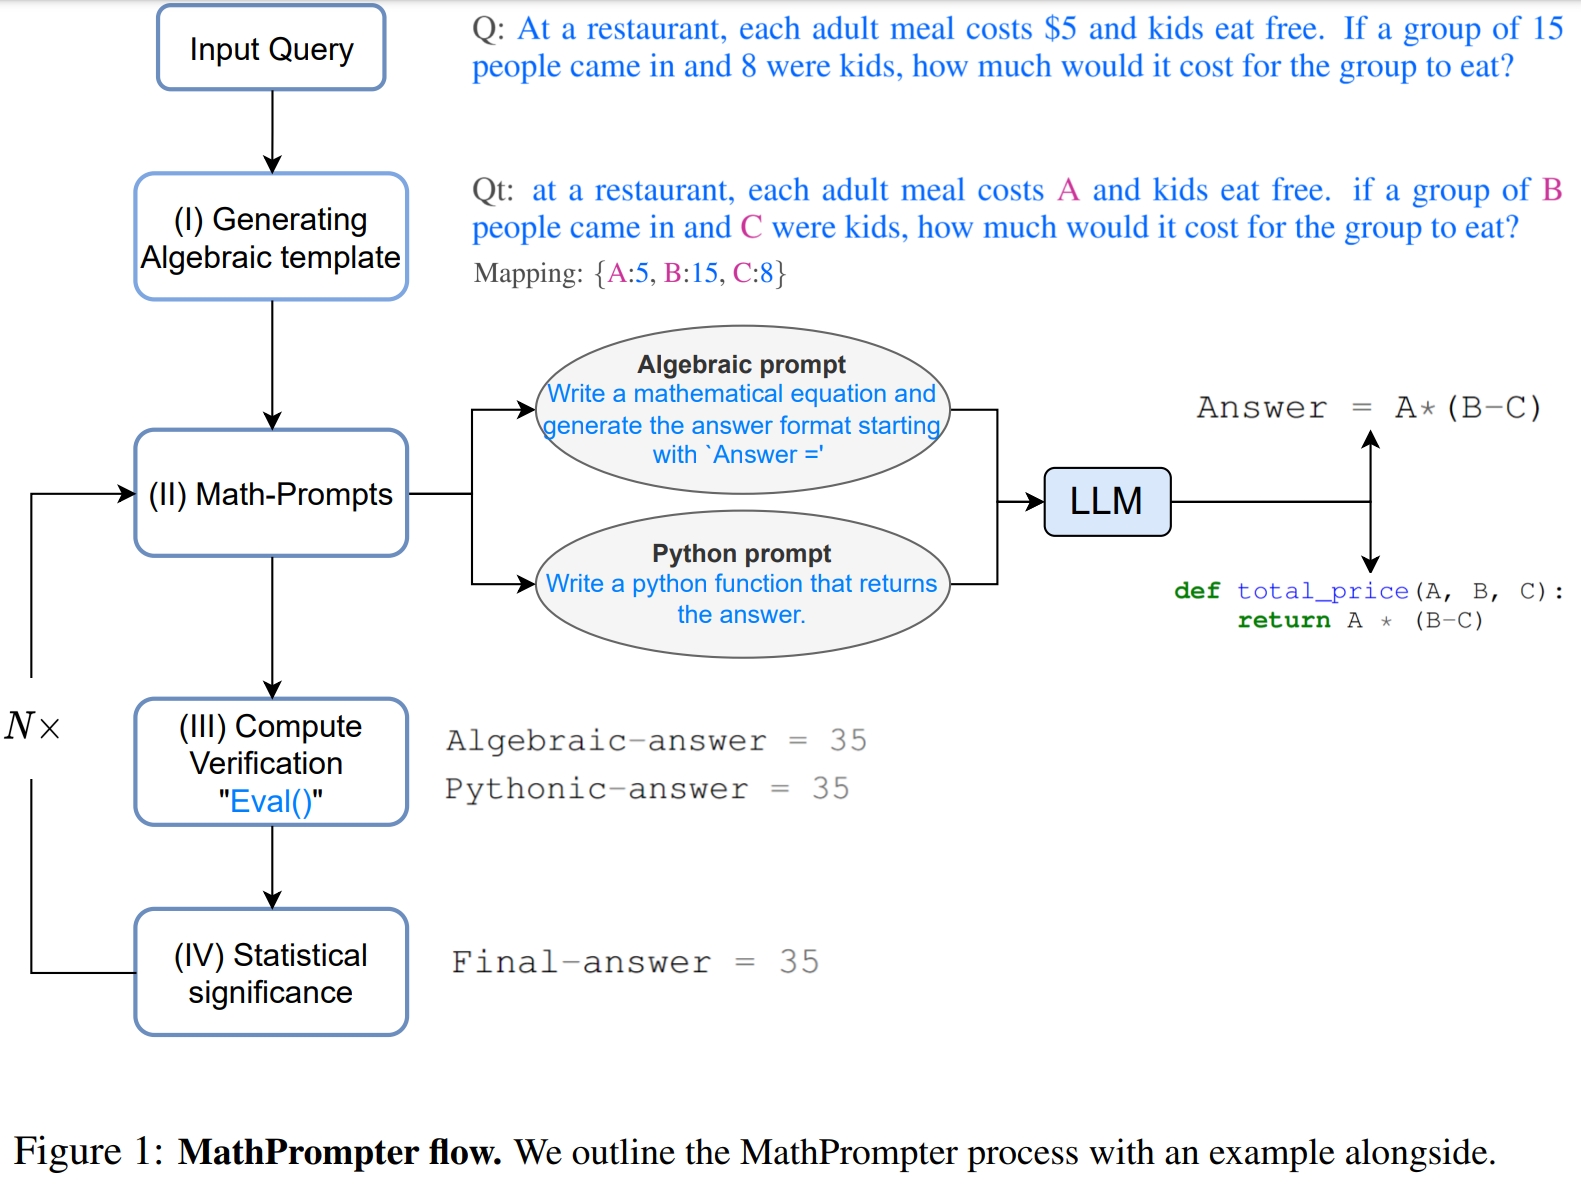

Best Examples:

https://github.com/RamonKaspar/MathPrompter

https://huggingface.co/spaces/bigcode/Reasoning-with-StarCoder/blame/076bdf6c5c06a09dfe46fb4ce9dd4e47d98e2ee5/mathprompter.py

# References

-arXiv:2410.05915 [cs.CL]

-arXiv:2402.10200 [cs.CL]

-https://github.com/Alab-NII/chain-of-thought

-https://github.com/microsoft/ToRA

-https://microsoft.github.io/FLAML/blog/2023/06/28/MathChat/

-https://medium.com/syncedreview/microsofts-mathprompter-dramatically-improves-llm-performance-on-mathematical-reasoning-tasks-561b29c2353b

-https://github.com/RamonKaspar/MathPrompter/

-https://math.microsoft.com/